# Spatial Groupings (aquifer vs. regions)

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)

In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

In [6]:
import sys
sys.path.append("../neuralhydrology")

from neuralhydrology.evaluation.metrics import nse, mse, rmse, kge, fdc_fms, fdc_fhv, fdc_flv, calculate_all_metrics, calculate_metrics

# Read in the CAMELS data

In [7]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)
dynamic = ds

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Read MODELS (LSTM, FUSE)

In [8]:
from scripts.drafts.io_results import read_ensemble_results, read_fuse_data

In [9]:
ealstm_preds = read_ensemble_results(data_dir / "runs/ensemble_pet_ealstm")
lstm_preds = read_ensemble_results(data_dir / "runs/ensemble_pet")

In [10]:
raw_fuse_path = data_dir / "RUNOFF/FUSE"
fuse_data = read_fuse_data(raw_fuse_path, lstm_preds["obs"])

In [11]:
all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)

lstm_preds = lstm_preds.sel(
    station_id=all_stations_lstm, time=np.isin(lstm_preds.time, fuse_data.time)
)
ealstm_preds = ealstm_preds.sel(
    station_id=all_stations_ealstm, time=np.isin(ealstm_preds.time, fuse_data.time)
)
lstm_df = lstm_preds.to_dataframe().reset_index()

In [12]:
all_bias = []
for i in range(len(lstm_df.station_id.unique())):
    d = lstm_df.loc[lstm_df.station_id == lstm_df.station_id.unique()[i]]
    pbias = lambda obs, sim: (np.sum(obs - sim) / np.sum(obs)) * 100

    all_bias.append(pbias(d["obs"], d["sim"]))
    
all_bias = np.array(all_bias)

In [13]:
all_bias[~np.isnan(all_bias)].min()

-82.73894122184807

# All Errors in one data structure

In [14]:
from scripts.drafts.calculate_error_scores import calculate_all_data_errors, get_metric_dataframes_from_output_dict
from scripts.drafts.delta_error import DeltaError

In [15]:
all_errors = pickle.load((data_dir / "RUNOFF/all_metrics.pkl").open("rb"))
all_metrics = pickle.load((data_dir / "RUNOFF/all_metrics.pkl").open("rb"))

# Skill Score metrics

In [16]:
from scripts.drafts.skill_score import create_skill_score, create_all_skill_scores
from scripts.drafts.plots import plot_cdf

In [17]:
skill_scores = create_all_skill_scores(all_metrics)

SS vs. Benchmark: 100%|██████████| 7/7 [00:00<00:00, 78.87it/s]


# Spatial Stuff

In [18]:
import geopandas as gpd

# catchment shapefiles
shp_path = data_dir / "CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
assert shp_path.exists()

geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}
geo_df.to_crs(epsg=4326)

# Station Gauge lat-lon points (already in EPSG:4326)
d = static[["gauge_lat", "gauge_lon"]].to_dataframe()
points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
points.name = "geometry"

In [19]:
assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")
# uk.plot(facecolor='none', edgecolor='k')

In [20]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
names = static["gauge_name"].to_dataframe()
poly = geo_df.set_index("ID").loc[catchment_ids].join(names).to_crs(epsg=4326)
all_poly = geo_df.set_index("ID").join(names).to_crs(epsg=4326)
pts = gpd.GeoDataFrame(points.loc[catchment_ids]).join(names)
all_points = gpd.GeoDataFrame(points).join(names)

# Regional Performances

In [21]:
[d for d in (data_dir / "RUNOFF/gis_data_Tommy").glob("*/*.shp")]

[PosixPath('/cats/datastore/data/RUNOFF/gis_data_Tommy/UK_Lakes/UK_Lakes.shp'),
 PosixPath('/cats/datastore/data/RUNOFF/gis_data_Tommy/UK_hydroclimate_regions_Harrigan_et_al_2018/UK_Hydro_Regions_ESP_HESS.shp'),
 PosixPath('/cats/datastore/data/RUNOFF/gis_data_Tommy/Aquifers/Uk_HydroGeology_Simplified.shp')]

In [22]:
lakes = gpd.read_file(data_dir / "RUNOFF/gis_data_Tommy" / "UK_Lakes/UK_Lakes.shp").to_crs(epsg=4326)
hydro_regions = gpd.read_file(data_dir / "RUNOFF/gis_data_Tommy" / "UK_hydroclimate_regions_Harrigan_et_al_2018/UK_Hydro_Regions_ESP_HESS.shp").to_crs(epsg=4326)
hydro_regions = hydro_regions.loc[~np.isin(hydro_regions["NAME"], ["Northern Ireland", "Republic of Ireland"])]
aquifers = gpd.read_file(data_dir / "RUNOFF/gis_data_Tommy" / "Aquifers/Uk_HydroGeology_Simplified.shp").to_crs(epsg=4326)

In [23]:
region_abbrs = {
    'Western Scotland': "WS",
    'Eastern Scotland': "ES",
    'North-east England': "NEE",
    'Severn-Trent': "ST",
    'Anglian': "ANG",
    'Southern England': "SE",
    'South-west England & South Wales': "SWESW",
    'North-west England & North Wales (NWENW)': "NWENW",
}

def get_region_station_within(stations: gpd.GeoDataFrame, hydro_regions: gpd.GeoDataFrame):
    # find the region that a station belongs WITHIN
    # create a list of strings/nans for each station 
    region_dict = {}
    for region, geom in zip(hydro_regions["NAME"], hydro_regions["geometry"]):
        isin_region = ([p.within(geom) for p in stations])
        region_dict[region] = [(region if item else np.nan) for item in isin_region]

    region_cols = pd.DataFrame(region_dict)

    # copy non-null values from the right column into the left and select left
    # https://stackoverflow.com/a/49908660
    regions_list = (region_cols.bfill(axis=1).iloc[:, 0]).rename("region")
    regions_list.index = points.index

    return regions_list

In [24]:
regions_list = get_region_station_within(points, hydro_regions)
all_points = gpd.GeoDataFrame(points).join(names).join(regions_list)
# region_factos = pd.Categorical(all_points["region"])

In [25]:
from typing import List, Dict, Tuple

def get_region_and_UK_wide_metric(df: pd.DataFrame, agg: str = "median", models: List[str] = ['TOPMODEL', 'ARNOVIC', 'PRMS', 'SACRAMENTO', 'EALSTM', 'LSTM',]) -> pd.DataFrame:
    assert all(np.isin(["region", "LSTM"], df.columns))
    if agg == "median":
        # Median in each region
        med_region = df.groupby("region").median()[models]
        med_region.values.shape

        # Append Whole of UK Median (as a region)
        med_values = np.vstack([df.median()[models].values, med_region.values])

    elif agg == "mean":
        # Mean in each region
        med_region = df.groupby("region").mean()[models]
        med_region.values.shape

        # Append Whole of UK Median (as a region)
        med_values = np.vstack([df.mean()[models].values, med_region.values])
    else:
        assert False
        
    region = ["UK"] + [region_abbrs[l] for l in med_region.index.values]
    columns = med_region.columns
    med_region = pd.DataFrame(med_values, columns=columns, index=region)
    return med_region


def plot_matrix_of_each_region_and_model(
    df: pd.DataFrame,
    agg: str = "median",
    models: List[str] =  ['TOPMODEL', 'ARNOVIC', 'PRMS', 'SACRAMENTO', 'EALSTM', 'LSTM',],
    kwargs: Dict = {"cmap": "blues"}
):
    assert all(np.isin(["region", "region_abbr"], df.columns)), f"Expect [region region_abbr] to be in {df.columns}"
    assert agg in ["mean", "median"], "Expect agg to be one of median, mean"
    med_region = get_region_and_UK_wide_metric(df, agg=agg, models=models)

    # https://stackoverflow.com/a/40890587
    fig, ax = plt.subplots(figsize=(12, 8))

    intersection_matrix = med_region.values

    ax.imshow(intersection_matrix.T, **kwargs)

    for region_ix in range(intersection_matrix.shape[0]):
        for model_ix in range(intersection_matrix.shape[1]):
            c = intersection_matrix[region_ix, model_ix]
            ax.text(region_ix, model_ix, f"{c:.2f}", va='center', ha='center')

    ax.set_ylabel("Model")
    ax.set_xlabel("Region")
    ax.set_xticklabels([''] + list(med_region.index))
    ax.set_yticklabels([''] + list(med_region.columns))
    
    return ax

Text(0.5, 1.0, 'Median UK and Regional KGESS')

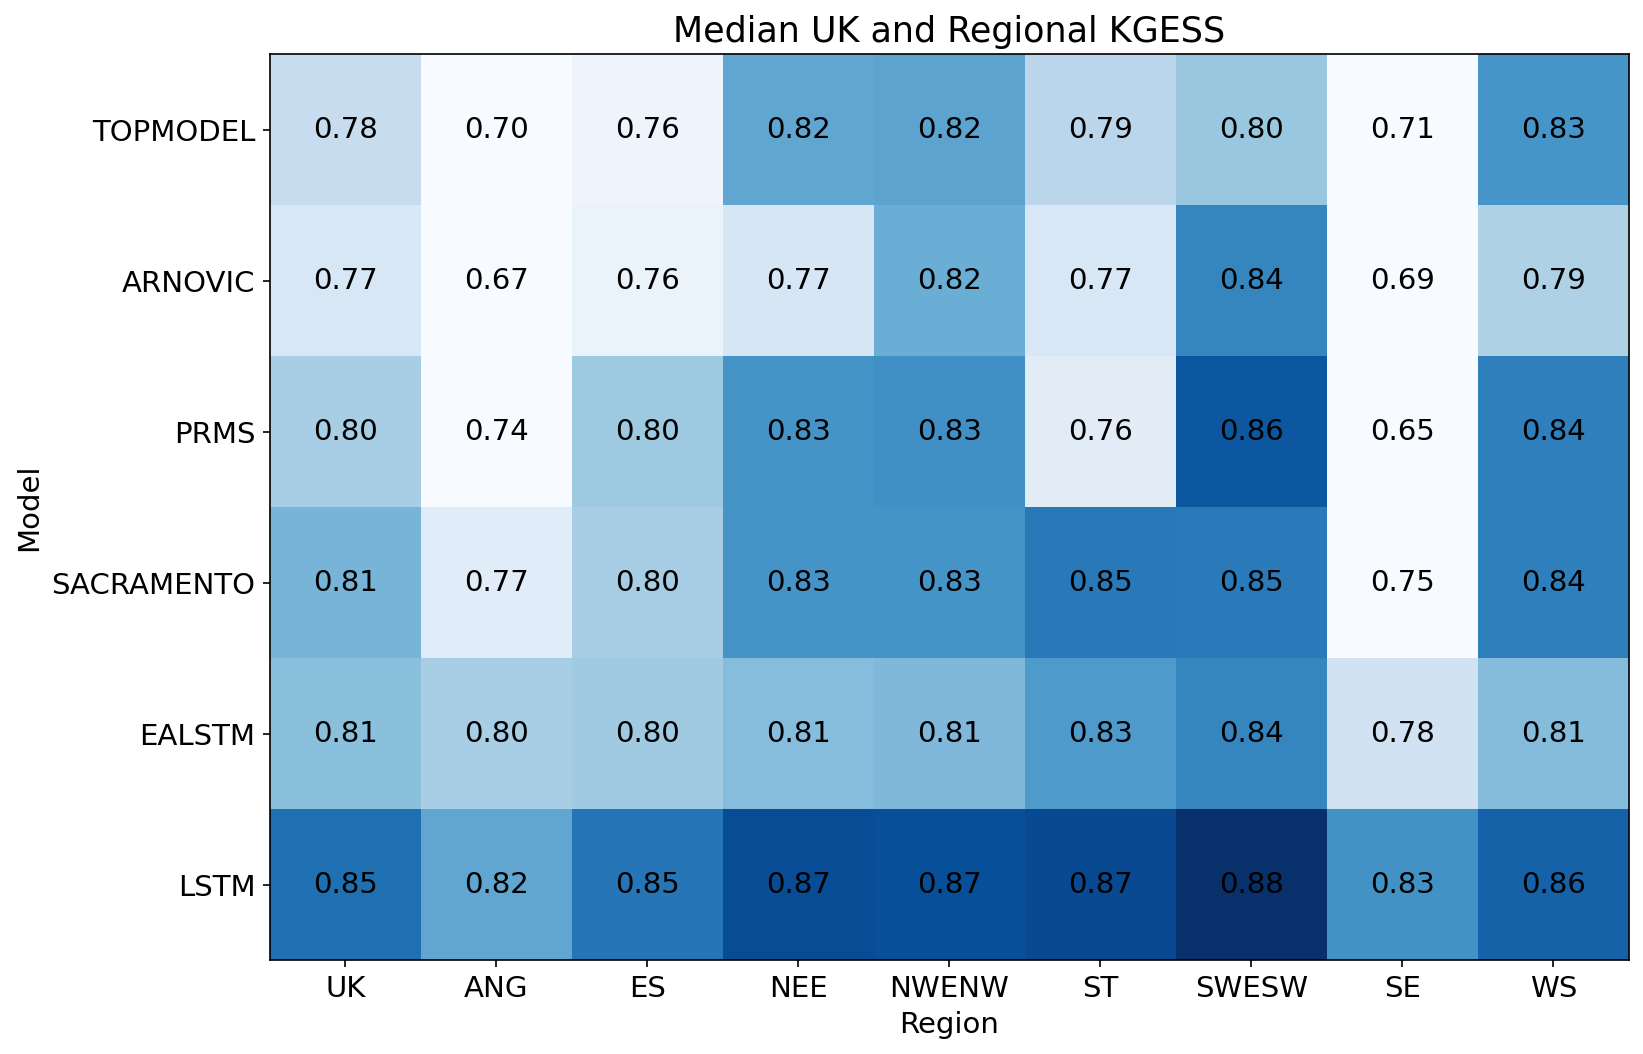

In [26]:
skill_score = True
metric = "kge"

vmin = 0.75
vmax = None
cmap = "Blues"
agg = "median"

# select table of metrics (skill-score or raw)
if skill_score:
    df = skill_scores["climatology_doy"][metric].join(regions_list)
else:
    df = all_metrics[metric].join(regions_list)

df["region_abbr"] = df["region"].map(region_abbrs)

plot_matrix_of_each_region_and_model(df, agg=agg, kwargs={"vmin": vmin, "vmax": vmax, "cmap": cmap})
ax = plt.gca()
ax.set_title(f"{agg.capitalize()} UK and Regional {metric.upper()}{'SS' if skill_score else ''}")

In [27]:
# df.groupby("region").count()
med_region = get_region_and_UK_wide_metric(df, agg="median")
print(med_region.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  TOPMODEL &  ARNOVIC &  PRMS &  SACRAMENTO &  EALSTM &  LSTM \\
\midrule
UK    &      0.78 &     0.77 &  0.80 &        0.81 &    0.81 &  0.85 \\
ANG   &      0.70 &     0.67 &  0.74 &        0.77 &    0.80 &  0.82 \\
ES    &      0.76 &     0.76 &  0.80 &        0.80 &    0.80 &  0.85 \\
NEE   &      0.82 &     0.77 &  0.83 &        0.83 &    0.81 &  0.87 \\
NWENW &      0.82 &     0.82 &  0.83 &        0.83 &    0.81 &  0.87 \\
ST    &      0.79 &     0.77 &  0.76 &        0.85 &    0.83 &  0.87 \\
SWESW &      0.80 &     0.84 &  0.86 &        0.85 &    0.84 &  0.88 \\
SE    &      0.71 &     0.69 &  0.65 &        0.75 &    0.78 &  0.83 \\
WS    &      0.83 &     0.79 &  0.84 &        0.84 &    0.81 &  0.86 \\
\bottomrule
\end{tabular}



# Overlap with aquifers

In [28]:
from shapely.ops import unary_union  # cascaded_union, 
from typing import List, Optional, Tuple, Dict


def get_overlapping_catchments(polygons: gpd.GeoDataFrame, aquifers: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # join aquifers into one aquifer plot
    one_aquifer = one_aquifer = unary_union([p for p in aquifers.geometry])
    one_aquifer = gpd.GeoSeries(one_aquifer)
    
    # spatial join w/ intersect
    one_aquifer = gpd.GeoDataFrame(one_aquifer.rename("geometry"))
    sj = gpd.sjoin(all_poly, one_aquifer, how='inner',op='intersects')
    return sj



def get_stations_inside_polygon(stations: gpd.GeoSeries, aquifers: gpd.GeoDataFrame) -> List[bool]:
    one_aquifer = unary_union([p for p in aquifers.geometry])
    one_aquifer = gpd.GeoSeries(one_aquifer)

    isin_aquifer = ([p.within(one_aquifer.iloc[0]) for p in stations])
    return isin_aquifer

In [29]:
sj = get_overlapping_catchments(all_poly, aquifers)
overlapping_stations = points.loc[sj.index]

In [30]:
# f, ax = plt.subplots(figsize=(12, 8))
# uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
# sj.plot(ax=ax, alpha=0.4)
# points.plot(ax=ax, color="grey", markersize=1, alpha=0.4)
# overlapping_stations.plot(markersize=15, edgecolor="C1", facecolor="C1", ax=ax)
# aquifers.plot(ax=ax, facecolor="none", alpha=0.8, edgecolor="k")

# ax.axis('off')
# ax.set_xlim([-8.2, 2.1])
# ax.set_ylim([50, 59.5])

(50.0, 59.5)

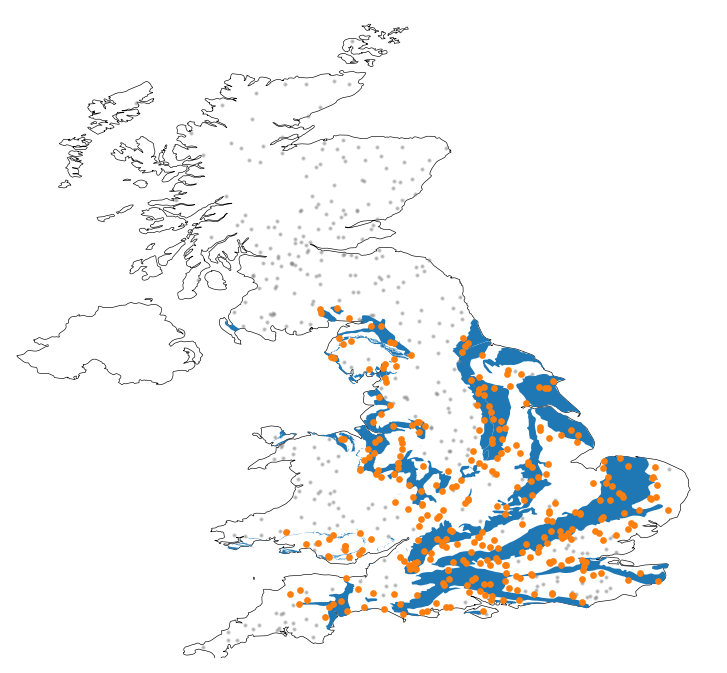

In [31]:
scale = 1.2
f, ax = plt.subplots(figsize=(5*scale, 8*scale))
uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
aquifers.plot(ax=ax)
points.plot(ax=ax, color="grey", markersize=1, alpha=0.4)
overlapping_stations.plot(ax=ax, color="C1", markersize=5, alpha=1)

ax.axis('off')
ax.set_xlim([-8.2, 2.1])
ax.set_ylim([50, 59.5])

# Analyse aquifer vs. non-aquifer stations

In [32]:
aquifer_stations = overlapping_stations

In [33]:
metric = "nse"
clip = (0, 1)


metric_aquifer = all_metrics[metric].loc[np.isin(all_metrics[metric].index, aquifer_stations.index)]
metric_non_aquifer = all_metrics[metric].loc[~np.isin(all_metrics[metric].index, aquifer_stations.index)]

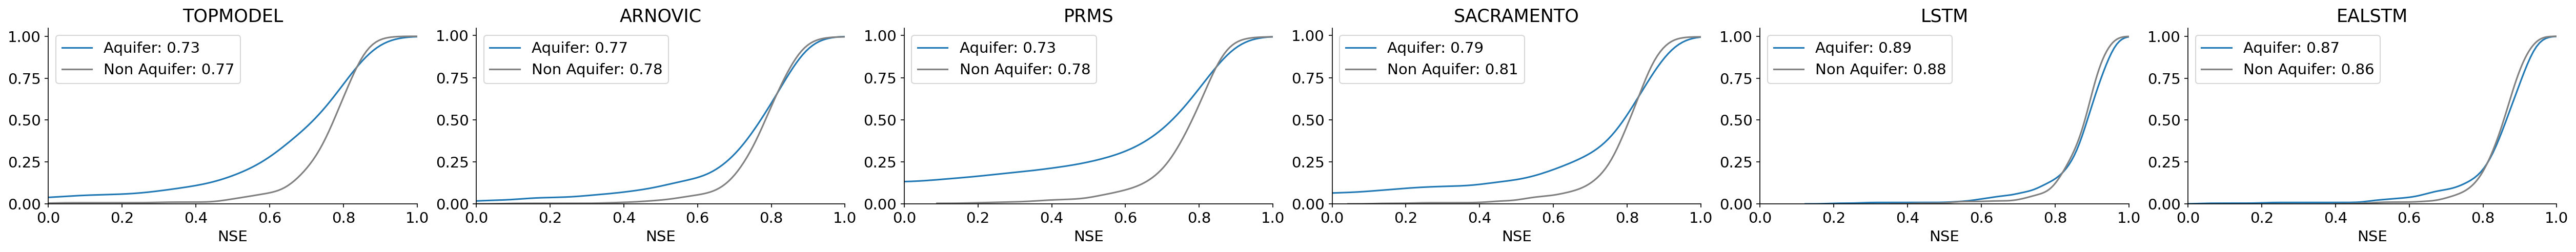

In [34]:
models = ["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]
models = ["LSTM", "EALSTM"]
models = ["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO", "LSTM", "EALSTM"]

n_rows = 6
n_cols = (len(models) % n_rows) + (len(models) // n_rows)
scale = 1.4

f, axs = plt.subplots(n_cols, n_rows, figsize=(4*n_rows*scale, 2.5*n_cols*scale), sharex=True)

for ix, model in enumerate(models):
    ax = axs[np.unravel_index(ix, (n_rows))]
    sns.kdeplot(metric_aquifer[model], label=f"Aquifer: {metric_aquifer[model].median():.2f}", cumulative=True, ax=ax, clip=clip)
    sns.kdeplot(metric_non_aquifer[model], label=f"Non Aquifer: {metric_non_aquifer[model].median():.2f}", cumulative=True, ax=ax, clip=clip, color="grey")
    ax.legend(loc="upper left")
    ax.set_xlim(0, 1)
    ax.set_title(model)
    sns.despine()
    ax.set_xlabel("NSE")
    
plt.tight_layout()

# Analyze the GB context

In [36]:
assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")
# uk.plot(facecolor='none', edgecolor='k')

In [82]:
!git pull
from scripts.drafts.plots import _plot_geospatial

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/esowc/ml_drought
   804696e..6a23586  init/runoff -> origin/init/runoff
Updating 804696e..6a23586
Fast-forward
 scripts/drafts/plots.py | 1 +
 1 file changed, 1 insertion(+)


In [83]:
d = static[["gauge_lat", "gauge_lon"]].to_dataframe()
points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index, crs="epsg:4326")
points.name = "geometry"

In [152]:
# calculate most common landcover type
landcover_vars = [ 'dwood_perc',
 'ewood_perc',
 'grass_perc',
 'shrub_perc',
 'crop_perc',
 'urban_perc',
 'inwater_perc',
 'bares_perc',
]

lcover = static[landcover_vars].to_array()
# check close to 100%
lcover.sum(dim="variable")

most_common_lcover_type = lcover.isel(variable=(lcover.argmax(dim="variable")))["variable"].to_dataframe().iloc[:, 0].rename("landcover")

In [156]:
# metric_data = gpd.GeoDataFrame(ds[["precipitation", "pet", "temperature", "discharge_spec"]].mean(dim="time").to_dataframe().join(points))
gdf = gpd.GeoDataFrame((static.to_dataframe()[["baseflow_index", "q_mean", "pet_mean", "p_mean", "dpsbar"]]).join(points)).join(most_common_lcover_type)

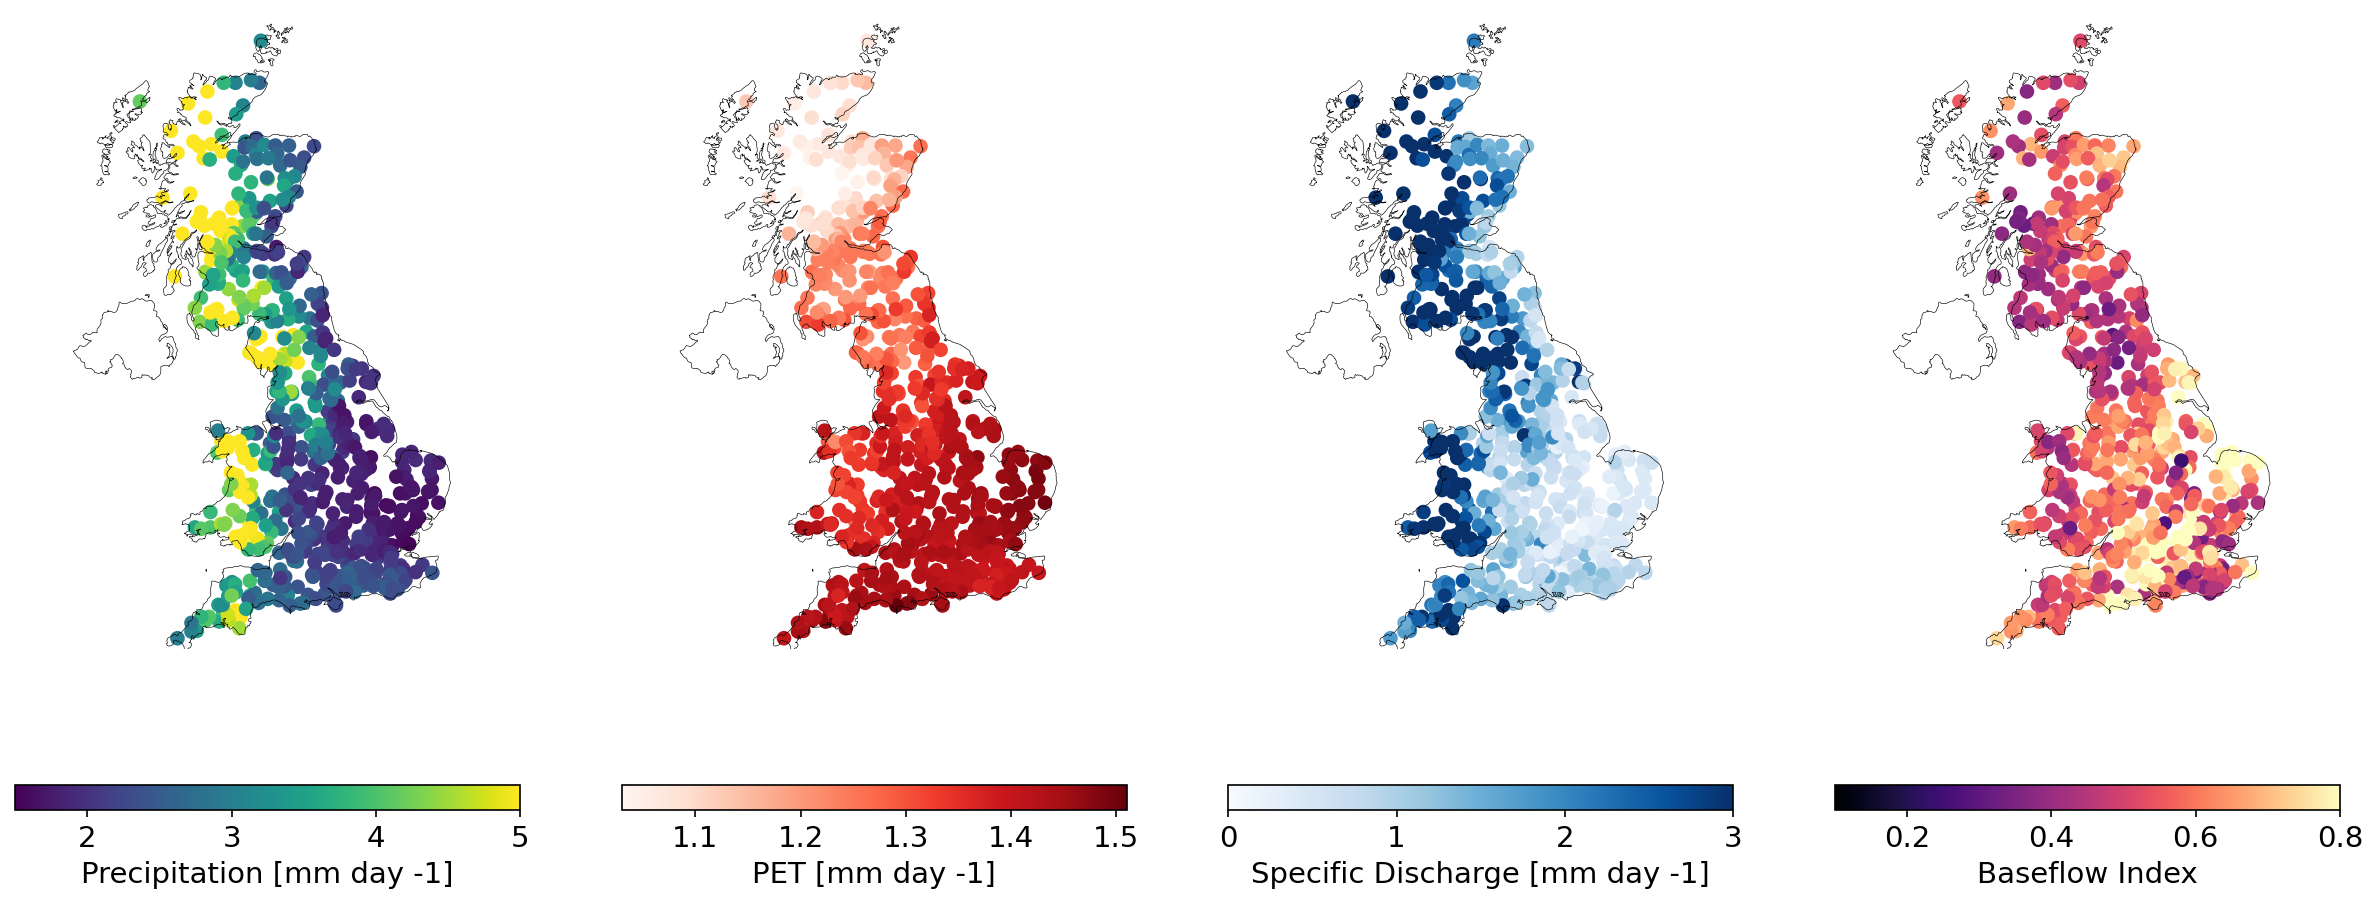

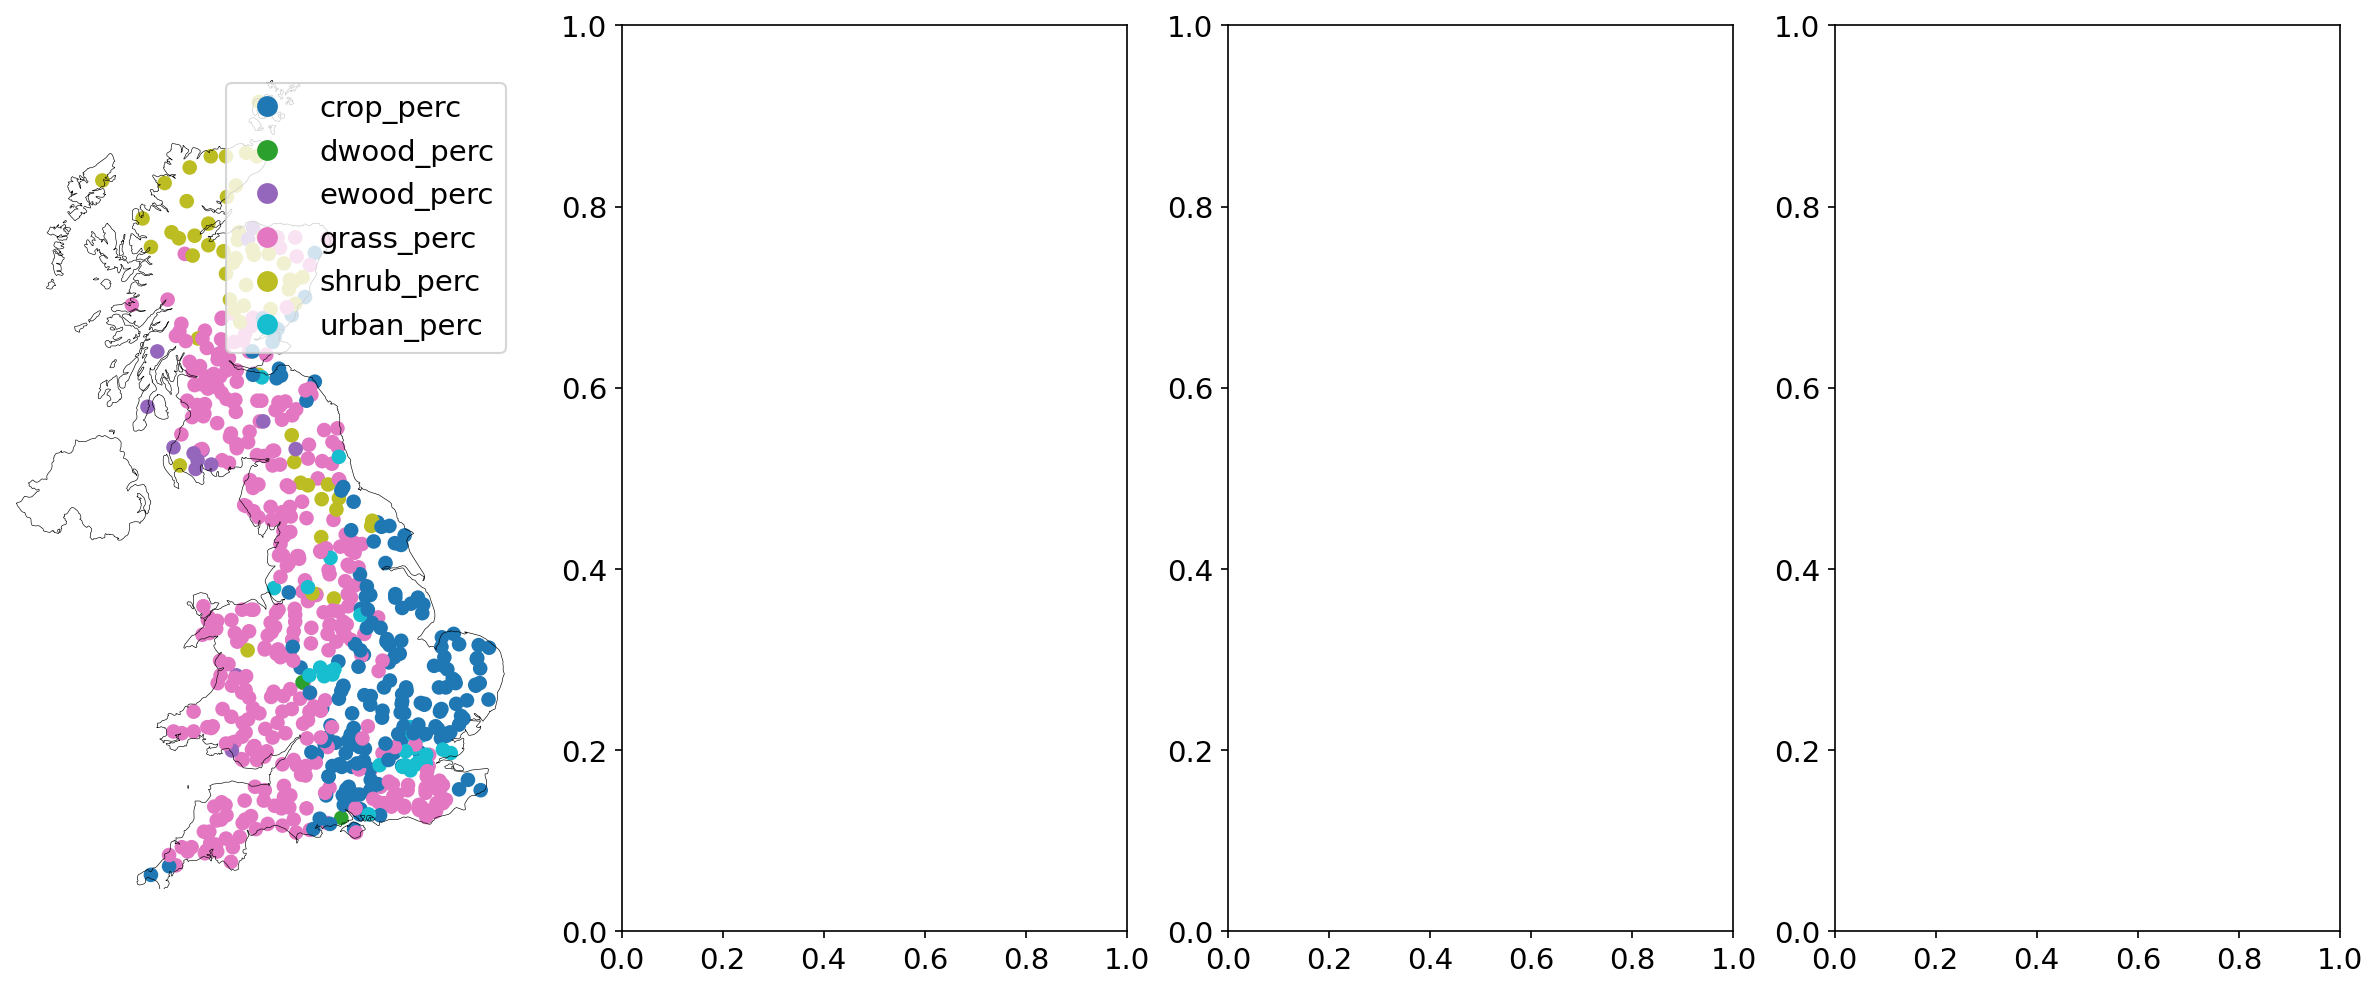

In [169]:
lookup = {
    "p_mean": dict(cmap="viridis", vmin=1.5, vmax=5, legend_kwds={'label': "Precipitation [mm day -1]", 'orientation': "horizontal"}),
    "pet_mean": dict(cmap="Reds", vmin=None, vmax=None, legend_kwds={'label': "PET [mm day -1]", 'orientation': "horizontal"}),
    "q_mean": dict(cmap="Blues", vmin=0, vmax=3, legend_kwds={'label': "Specific Discharge [mm day -1]", 'orientation': "horizontal"}),
    "baseflow_index": dict(cmap="magma", vmin=0.1, vmax=0.8, legend_kwds={'label': "Baseflow Index", 'orientation': "horizontal"}), 
    "landcover": dict(cmap=None, vmin=None, vmax=None, legend_kwds={}),
}
#     "dpsbar": dict(cmap="magma", vmin=None, vmax=None, legend_kwds={'label': "Mean Distance Per Slope", 'orientation': "horizontal"}),
#     "gauge_elev": dict(cmap="magma", vmin=None, vmax=None, legend_kwds={'label': "Mean Gauge Elevation", 'orientation': "horizontal"}),
#     "frac_snow": dict(cmap="magma", vmin=None, vmax=None, legend_kwds={'label': "Fraction of Precip falling as Snow", 'orientation': "horizontal"}),


f, axs = plt.subplots(1, 4, figsize=(5*4, 8))
for ix, variable in enumerate([k for k in lookup.keys()][:4]):
    ax = axs[ix]
    ax = _plot_geospatial(gdf, variable, ax=ax,
                     kwargs=lookup[variable]
    )

f, axs = plt.subplots(1, 4, figsize=(5*4, 8))
for ix, variable in enumerate([k for k in lookup.keys()][4:]):
    ax = axs[ix]
    ax = _plot_geospatial(gdf, variable, ax=ax,
                     kwargs=lookup[variable]
    )

In [115]:
print([v for v in static.data_vars])

['inter_high_perc', 'inter_mod_perc', 'inter_low_perc', 'frac_high_perc', 'frac_mod_perc', 'frac_low_perc', 'no_gw_perc', 'low_nsig_perc', 'nsig_low_perc', 'gauge_name', 'gauge_lat', 'gauge_lon', 'gauge_easting', 'gauge_northing', 'gauge_elev', 'area', 'dpsbar', 'elev_mean', 'elev_min', 'elev_10', 'elev_50', 'elev_90', 'elev_max', 'sand_perc', 'sand_perc_missing', 'silt_perc', 'silt_perc_missing', 'clay_perc', 'clay_perc_missing', 'organic_perc', 'organic_perc_missing', 'bulkdens', 'bulkdens_missing', 'bulkdens_5', 'bulkdens_50', 'bulkdens_95', 'tawc', 'tawc_missing', 'tawc_5', 'tawc_50', 'tawc_95', 'porosity_cosby', 'porosity_cosby_missing', 'porosity_cosby_5', 'porosity_cosby_50', 'porosity_cosby_95', 'porosity_hypres', 'porosity_hypres_missing', 'porosity_hypres_5', 'porosity_hypres_50', 'porosity_hypres_95', 'conductivity_cosby', 'conductivity_cosby_missing', 'conductivity_cosby_5', 'conductivity_cosby_50', 'conductivity_cosby_95', 'conductivity_hypres', 'conductivity_hypres_missin

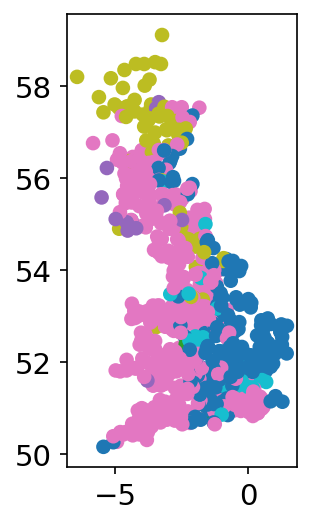

In [155]:
gpd.GeoDataFrame(most_common_lcover_type.to_frame().join(points)).plot("landcover")